<a href="https://colab.research.google.com/github/malcolmlett/ml-learning/blob/main/Learning_visualisations_v10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Visualisations v10: Capturing weights during training.
Troubleshooting on my robovac project has identified that to really understand the cause of failing gradients requires a complete break-down of the gradient calculation formula, collecting separate values for activations, weights, and gradients and the layers before, after, and on the target layer in question.

This notebook focuses on creating a callback for collecting the weights used at each iteration.

The final callback will be usable in a normal training function, as it doesn't require direct access to gradients or layer outputs.

In [1]:
import os
if os.path.isdir('repo'):
  # discard any local changes and update
  !cd repo && git reset --hard HEAD
  !cd repo && git fetch
else:
  !git clone https://github.com/malcolmlett/ml-learning.git repo

# lock to revision
#!cd repo && git checkout 65edb0b
!cd repo && git pull

import sys
sys.path.append('repo')

import train_observability_toolkit as tot
from importlib import reload
reload(tot)

Cloning into 'repo'...
remote: Enumerating objects: 353, done.
remote: Counting objects: 100% (187/187), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 353 (delta 111), reused 103 (delta 49), pack-reused 166 (from 1)
Receiving objects: 100% (353/353), 18.84 MiB | 15.70 MiB/s, done.
Resolving deltas: 100% (196/196), done.
Already up to date.


<module 'train_observability_toolkit' from '/content/repo/train_observability_toolkit.py'>

In [2]:
import train_observability_toolkit_test
reload(train_observability_toolkit_test)
reload(tot)
train_observability_toolkit_test.run_test_suite()

All train_observability_toolkit tests passed.


In [3]:
import keras
import tensorflow as tf
from tensorflow.keras import layers, models, datasets, optimizers, metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import sklearn
import sklearn.datasets
import time
import timeit
import tqdm

## Basic setup

train_X: (300, 2), train_Y: (300, 1), test_X: (100, 2), test_Y: (100, 1)


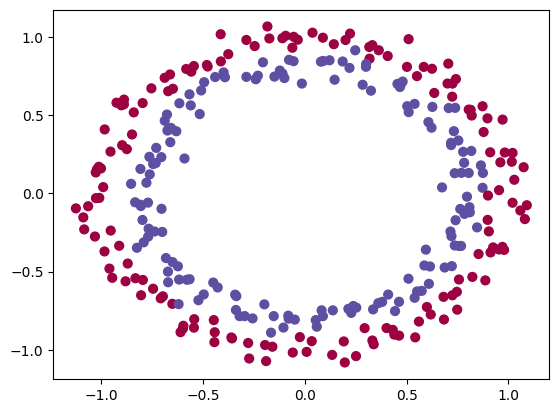

In [8]:
def plot_fit(history = None):
  pnum = 1

  plt.figure(layout='constrained')
  if history != None:
    plt.subplot(1,pnum,1)
    plt.plot(history.history['loss'])
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.yscale('log')
  plt.show()

def binary_classification_model(init_scheme):
  """
  init_scheme: one of "zeros", "large_normal", "he_normal"
  """
  if init_scheme == "zeros":
    kernel_initializer='zeros'
  elif init_scheme == "large_normal":
    kernel_initializer=tf.keras.initializers.RandomNormal(stddev=10.)
  elif init_scheme == "he_normal":
    kernel_initializer='he_normal'
  else:
    raise ValueError("Unknown init_scheme")

  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,)),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(5, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=kernel_initializer)
  ])

  return model

def binary_classification_dataset():
  np.random.seed(1)
  train_X, train_Y = sklearn.datasets.make_circles(n_samples=300, noise=.05)
  np.random.seed(2)
  test_X, test_Y = sklearn.datasets.make_circles(n_samples=100, noise=.05)
  train_X = train_X
  train_Y = train_Y.reshape((-1, 1))
  test_X = test_X
  test_Y = test_Y.reshape((-1, 1))
  return train_X, train_Y, test_X, test_Y

train_X, train_Y, test_X, test_Y = binary_classification_dataset()
print(f"train_X: {train_X.shape}, train_Y: {train_Y.shape}, test_X: {test_X.shape}, test_Y: {test_Y.shape}")

plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
plt.show()

In [5]:
model = binary_classification_model('he_normal')
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                     │ (None, 100)                 │             300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 5)                   │             505 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 1)                   │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41,611 (162.54 KB)

 Trainable params: 41,411 (161.76 KB)

 Non-trainable params: 200 (800.00 B)

## Weight collection callback
Now we'll use a custom callback function to collect weights during training.
We'll follow a consistent API that I want to expose out of all of the Gradient, Activation, and Weight collection callbacks:
```python
collection_sets = [
    {
      # one of:
      'layers': [Layer] # references to actual layers, OR
      'layer_indices': [int]  # list of layer indices, OR
      'layer_names': [string]  # list of layer names, OR
      'variable_indices': [int]  # list of variable indices according to model.variables, OR
      'trainable_variable_indices': [int]  # list of variable indices according to model.trainable_variables

      # one of:
      'density': float, default: 1.0  # fraction of units to collect outputs from, automatically sliced, OR
      'max_units': int, default: None  # max number of units to collect outputs from, automatically sliced, OR
      'slices': [slice]  # slices to use for each selected variable
    }
]
```

In [91]:
#from train_observability_toolkit import _normalize_collection_sets_for_variables, variable_indices_by_layer, _compute_common_stats_keys, _compute_common_stats, _append_dict_list, _index_by_identity

tf.config.run_functions_eagerly(False)
start = tf.timestamp()
model = binary_classification_model('he_normal')
model.compile(optimizer='adam', loss='binary_crossentropy')
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
variables = tot.VariableHistoryCallback(collection_sets=[{'layer_indices':[0,1,3]}], before_updates=True, per_step=True)
history = tot.fit(model, dataset.batch(32), epochs=5, verbose=0, callbacks=[tot.LessVerboseProgressLogger(), variables])

# saved variables
print(f"Model stats: {variables.model_stats.keys()} x {len(variables.model_stats['mean'])}")
print(f"Layer stats: {[len(layer_stat) if layer_stat else None for layer_stat in variables.layer_stats]}: {variables.layer_stats[0].keys()} x {len(variables.layer_stats[0]['mean'])}")
print(f"Variable stats: {[len(variable_stat) if variable_stat else None for variable_stat in variables.variable_stats]}: {variables.variable_stats[0].keys()} x {len(variables.variable_stats[0]['mean'])}")
print(f"callback.variables:")
for i, var_list in enumerate(variables.variables):
  if var_list is not None:
    print(f"variable {i}: len={len(var_list)} x type={type(var_list[0])} x {var_list[0].shape}")

print(f"callback.collected_variables:")
for i, var_list in enumerate(variables.collected_variables):
  if var_list is not None:
    print(f"variable {i}: len={len(var_list)} x type={type(var_list[0])} x {var_list[0].shape}")

Epoch     1 - 4.79s/epoch: loss: 0.6931  
Epoch     2 - 457.86ms/epoch: loss: 0.6931  
Epoch     3 - 463.26ms/epoch: loss: 0.6931  
Epoch     4 - 625.36ms/epoch: loss: 0.6931  
Epoch     5 - 1.27s/epoch: loss: 0.6931  
Model stats: dict_keys(['mean', 'min', 'max', 'std']) x 50
Layer stats: [4, 4, None, 4, 4, None, 4, 4, 4, 4]: dict_keys(['mean', 'min', 'max', 'std']) x 50
Variable stats: [4, 4, 4, 4, None, 4, 4, 4, 4, None, 4, 4, 4, 4, None, None, 4, 4, 4, 4]: dict_keys(['mean', 'min', 'max', 'std']) x 50
callback.variables:
variable 0: len=50 x type=<class 'tensorflow.python.framework.ops.EagerTensor'> x (2, 100)
variable 1: len=50 x type=<class 'tensorflow.python.framework.ops.EagerTensor'> x (100,)
variable 2: len=50 x type=<class 'tensorflow.python.framework.ops.EagerTensor'> x (100, 100)
variable 3: len=50 x type=<class 'tensorflow.python.framework.ops.EagerTensor'> x (100,)
variable 5: len=50 x type=<class 'tensorflow.python.framework.ops.EagerTensor'> x (100, 100)
variable 6: le

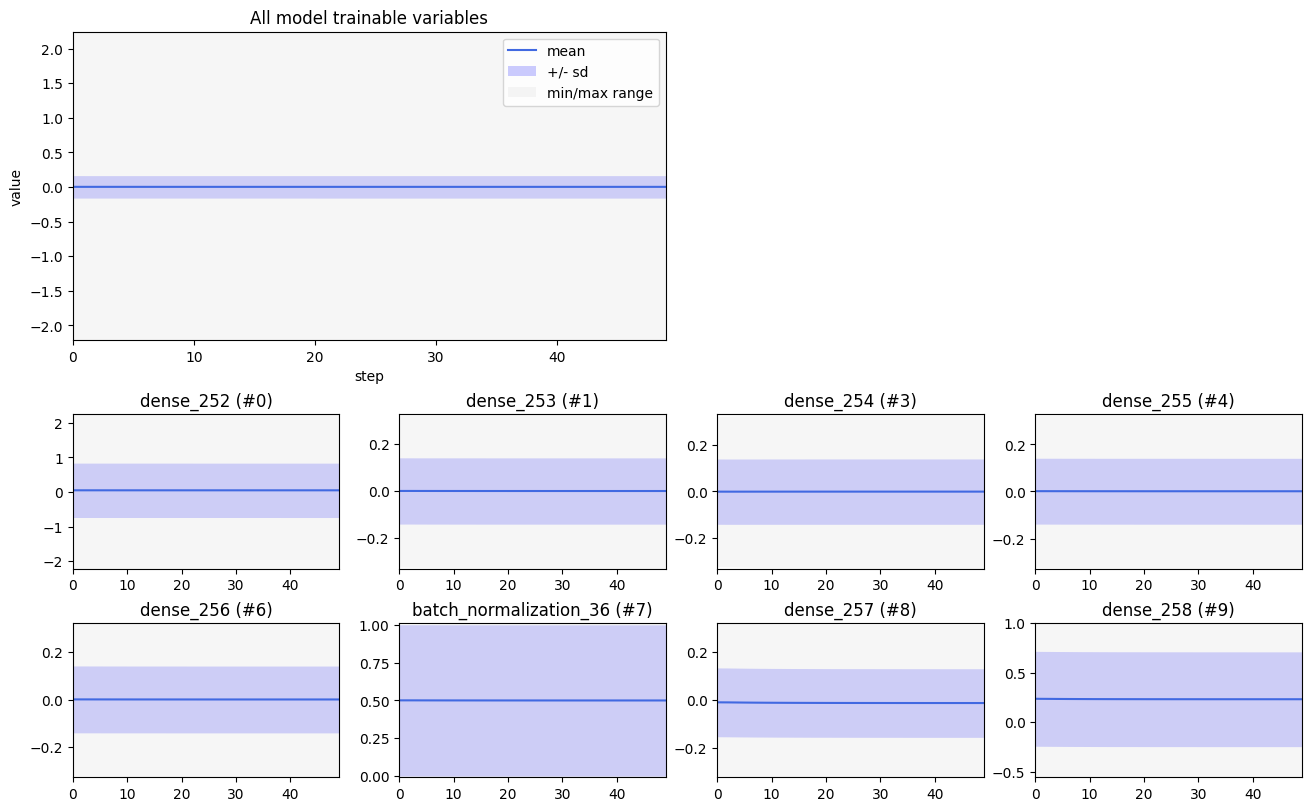

In [93]:
tot.plot_variable_history(variables)

## MNIST CNN

In [4]:
def mnist_cnn_model():
  model = tf.keras.Sequential([
    layers.Input(shape=(28, 28)),
    layers.Reshape((28, 28, 1)),
    layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', strides=2, activation='relu'),
    layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', strides=2, activation='relu'),
    layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', strides=2, activation='relu'),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(10, activation='softmax')  # Output layer for 10 classes
  ])
  model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

  return model

def mnist_dataset():
  np.random.seed(1)
  (x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
  # Normalize the data
  x_train = x_train / 255.0
  return x_train, y_train

train_X, train_Y = mnist_dataset()
print(f"train_X: {train_X.shape}, train_Y: {train_Y.shape}")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
train_X: (60000, 28, 28), train_Y: (60000,)


In [5]:
model = mnist_cnn_model()
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape (Reshape)                    │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 14, 14, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 7, 7, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 32)                  │          65,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 158,570 (619.41 KB)

 Trainable params: 158,570 (619.41 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Model training
reload(tot)
start = tf.timestamp()
model = mnist_cnn_model()
train_X, train_Y = mnist_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).batch(64)
variables = tot.VariableHistoryCallback(per_step=True)
history = model.fit(dataset, epochs=10, callbacks=[variables])
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")
plot_fit(history)

Epoch 1/10


938/938 ━━━━━━━━━━━━━━━━━━━━ 38s 36ms/step - accuracy: 0.8529 - loss: 0.4815
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 35s 37ms/step - accuracy: 0.9769 - loss: 0.0782
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 34s 36ms/step - accuracy: 0.9853 - loss: 0.0492
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 33s 35ms/step - accuracy: 0.9897 - loss: 0.0338
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 47s 41ms/step - accuracy: 0.9918 - loss: 0.0262
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 33s 35ms/step - accuracy: 0.9939 - loss: 0.0188
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 34s 36ms/step - accuracy: 0.9953 - loss: 0.0156
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 34s 37ms/step - accuracy: 0.9945 - loss: 0.0156
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 40s 36ms/step - accuracy: 0.9958 - loss: 0.0122
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 41s 36ms/step - accuracy: 0.9966 - loss: 0.0095
Total training time: 394.16 secs


NameError: name 'plot_fit' is not defined

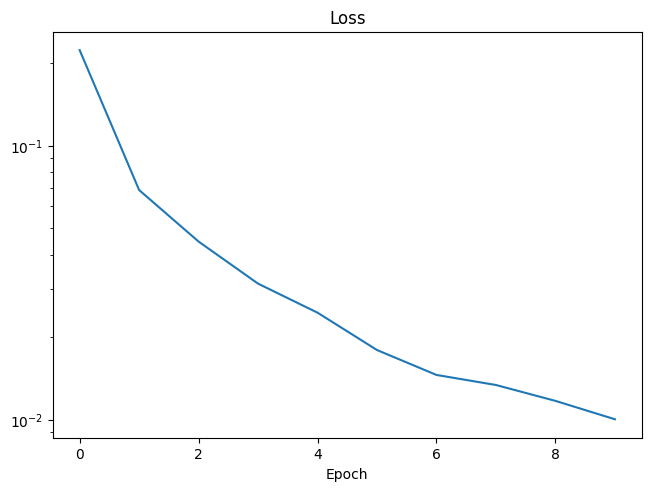

In [9]:
plot_fit(history)

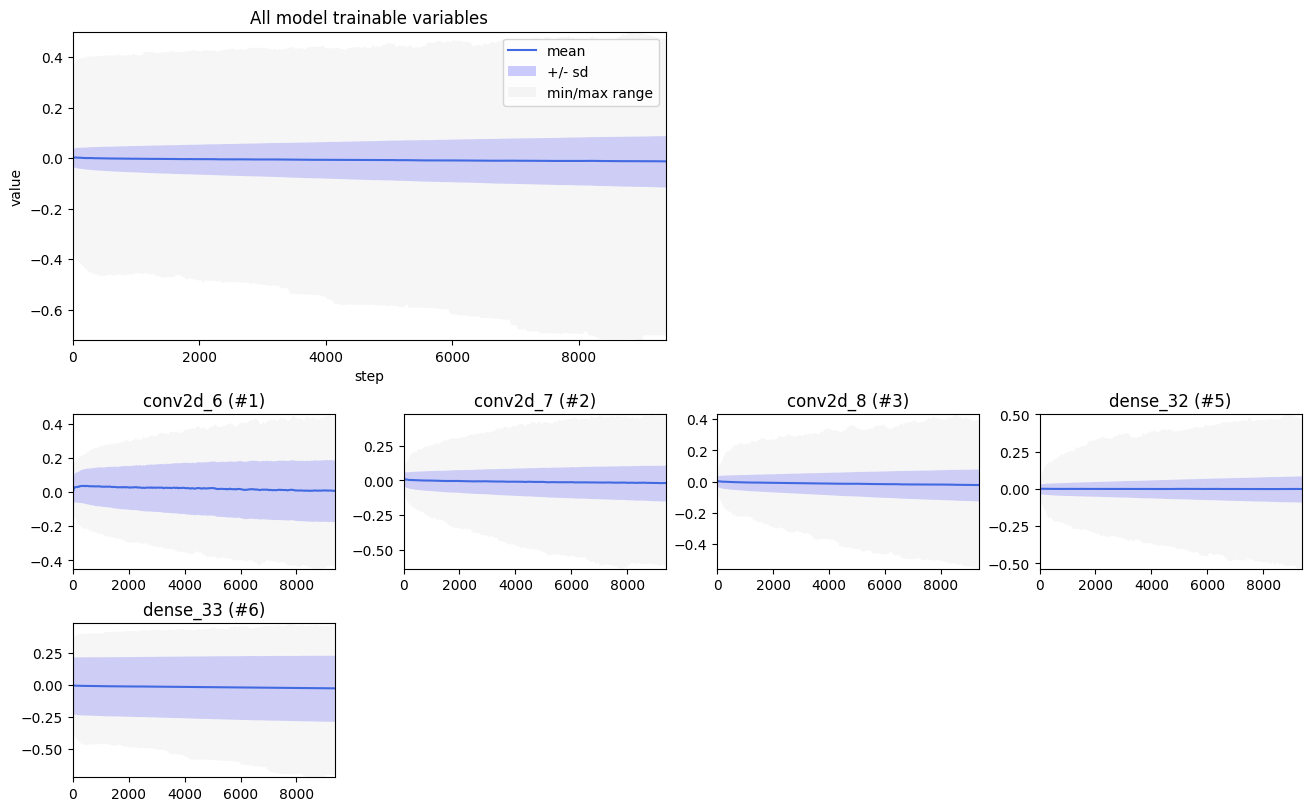

In [10]:
tot.plot_variable_history(variables)